In [1]:
import geopandas as gpd
import pandas as pd
import os
import glob
import requests
import zipfile
import matplotlib.pyplot as plt
import overpass

In [2]:
import warnings
warnings.simplefilter("ignore")

# Cadastral data
## Download 
Source: https://catastotn.tndigit.it/scarico-catasto-geometrico/it/index.html

In [3]:
# donwload_url = "https://catastotn.tndigit.it/export_semestrale_VL_PUBB/IDR0020230701_TIPOCATSH_CCXXX.zip"
# donwload_url = "https://catastotn.tndigit.it/export_semestrale_VL_PUBB/IDR0020240101_TIPOCATSH_CCXXX.zip"
download_url = "https://catastotn.tndigit.it/export_semestrale_VL_PUBB/IDR0020240701_TIPOCATSH_CCXXX.zip"
url_csv = "../data/catasto_rifugi.csv"

cadastre_huts_df = pd.read_csv(url_csv)
codici_catastali = cadastre_huts_df.codice_comune_catastale.unique()
codici_catastali

array([ 404,   44,  223,  439,  307,   66,  271,   94,  109,  429,  278,
        364,  302,  256,  247,  440,  286,  106,  353,  300,  263, -999,
        420,  258,  331,  272,  165,  125,  269])

In [4]:
# Request cadastral data for municipalities containing huts
gdflist = []
for codice in codici_catastali:
    codice = str(codice).zfill(3).replace(".0","")
    url = download_url.replace("XXX",codice)
    response = requests.get(url)
    # Elenca i nomi dei file che vuoi estrarre
    files_to_extract = []
    suffix = "_vl_uniqueparcel_poly"
    suffix = "_vl_parcel_poly"
    files_to_extract.append(codice + suffix + ".prj")
    files_to_extract.append(codice + suffix + ".shp")
    files_to_extract.append(codice + suffix + ".shx")
    files_to_extract.append(codice + suffix + ".dbf")
    if response.status_code == 200:
        with open("file.zip", "wb") as file:
            file.write(response.content)
        with zipfile.ZipFile("file.zip", "r") as zip_ref:
            for file_name in zip_ref.namelist():
                if file_name in files_to_extract:
                    zip_ref.extract(file_name)
        gdf = gpd.read_file(codice + suffix + ".shp")
        crs = gdf.crs
        gdflist.append(gdf)
        os.remove("file.zip")
        for shp in files_to_extract:
            os.remove(shp)
parcels = gpd.GeoDataFrame(pd.concat(gdflist, ignore_index=True), crs=crs)

In [5]:
parcels

,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry
0,P,141,404,N,YES,"POLYGON ((659366.399 5083222.897, 659376.619 5..."
1,P,142/1,404,N,YES,"POLYGON ((659384.01 5083211.905, 659379.344 50..."
2,P,143/1,404,N,YES,"POLYGON ((659384.01 5083211.905, 659370.14 508..."
3,P,4534,404,N,YES,"POLYGON ((659212.558 5083151.002, 659195.713 5..."
4,P,.906,404,N,YES,"POLYGON ((659361.867 5083203.976, 659370.14 50..."
...,...,...,...,...,...,...
188570,C,.408,269,S,YES,"POLYGON ((628368.96 5135187.904, 628369.048 51..."
188571,C,.409,269,S,YES,"POLYGON ((628211.709 5135183.252, 628214.739 5..."
188572,C,.413/1,269,S,YES,"POLYGON ((628232.885 5135250.9, 628226.315 513..."
188573,C,.678,269,S,YES,"POLYGON ((627311.949 5135149.424, 627321.812 5..."


In [6]:
parcels = parcels.to_crs(epsg=4326)

In [7]:
#parcels.plot()

I only need the parcels of the huts, which I know the codes (PT_CODE) from ../data/catasto_rifugi.csv, so I filter and save as a new dataframe

In [8]:
polygons_gdf = gpd.GeoDataFrame()
for idx, rif in cadastre_huts_df.iterrows():
  rif_particella = parcels[(parcels['PT_CODE'] == rif['codice_part_ed']) & (parcels['PT_CCAT'] == rif['codice_comune_catastale'])]
  if not rif_particella.empty:
    polygons_gdf = pd.concat([polygons_gdf, rif_particella])
  else:
    print(rif['rifugio_nome'], "not found!") # should be only Tonini

Spruggio - "G.Tonini" not found!


Each hut is registered with multiple geometries for the same parcel code, we can plot them together to see the total area of the hut:

<Axes: >

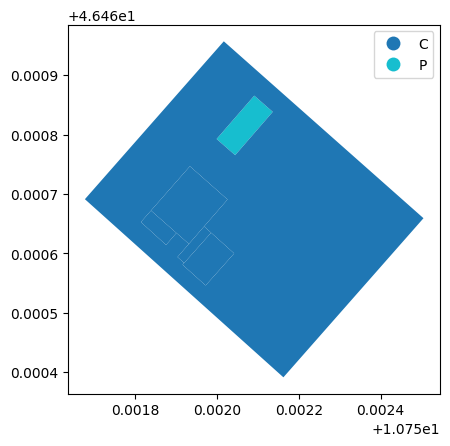

In [9]:
# Rifugio Dorigoni
polygons_gdf[(polygons_gdf['PT_CODE'] == "5239/2") & (polygons_gdf['PT_CCAT'] == 300)].plot(column='PT_TYPE', legend=True)

In [10]:
# Save in a file (optional)
polygons_gdf.to_file("../data/huts_parcels_downloaded.geojson")

## Hut names

In [11]:
polygons_gdf = gpd.read_file('../data/huts_parcels_downloaded.geojson')
polygons_gdf.head(5)

,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry
0,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733..."
1,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,..."
2,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ..."
3,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007..."
4,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042..."


In [12]:
# Hut names in the cadastral data
cadastre_huts_df = pd.read_csv('../data/catasto_rifugi.csv')
cadastre_huts_df.head(5)

,num,rifugio_nome,codice_comune_catastale,nome_comune_catastale,codice_part_ed,codice_part_f,note
0,1,"Alpe Pozza - ""V.Lancia""",404,TRAMBILENO,.690,-999,NaN
1,2,"Altissimo - ""D.Chiesa""",44,BRENTONICO,.1367,-999,NaN
2,3,Antermoia,223,MAZZIN,.329,-999,NaN
3,4,"Bindesi - ""P.Prati""",439,VILLAZZANO,.894,-999,NaN
4,5,"Bocca di Trat - ""N.Pernici""",307,RIVA,.1886,185/2,NaN


In [13]:
# Add names to each parcel using a merge with the .csv
polygons_gdf = polygons_gdf.merge(cadastre_huts_df[['codice_part_ed', 'rifugio_nome']], 
                                  left_on='PT_CODE', right_on='codice_part_ed', how='left')
polygons_gdf = polygons_gdf.drop(columns=['codice_part_ed'])

# Reorder columns to move 'rifugio_nome' to the first position
cols = list(polygons_gdf.columns)
cols.remove('rifugio_nome')
cols.insert(0, 'rifugio_nome')
polygons_gdf = polygons_gdf[cols]

polygons_gdf.head(5)

,rifugio_nome,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry
0,"Alpe Pozza - ""V.Lancia""",C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733..."
1,"Alpe Pozza - ""V.Lancia""",P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,..."
2,"Alpe Pozza - ""V.Lancia""",C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ..."
3,"Altissimo - ""D.Chiesa""",P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007..."
4,"Altissimo - ""D.Chiesa""",C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042..."


<Axes: >

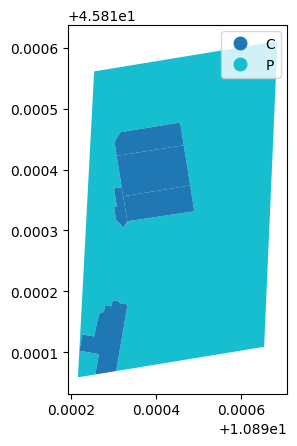

In [14]:
# Easier to plot single hut using name
polygons_gdf[polygons_gdf['rifugio_nome'] == 'Altissimo - "D.Chiesa"'].plot(column='PT_TYPE', legend=True)

## Centroids

In [15]:
# Group by 'rifugio_nome' and aggregate the geometries
grouped = polygons_gdf.dissolve(by='rifugio_nome')

# Calculate the centroid for each group
grouped['centroid'] = grouped.geometry.centroid

# Merge the centroid back to the original polygons_gdf
polygons_gdf = polygons_gdf.merge(grouped[['centroid']], on='rifugio_nome', how='left')

## Hut categories (from other .csv file)

In [16]:
# Load .csv
categorie_df = pd.read_csv('../data/categorie_rifugi.csv')
# Merge
polygons_gdf = polygons_gdf.merge(categorie_df, on='rifugio_nome', how='left')

# Reorder columns 
cols = list(polygons_gdf.columns)
cols_to_move = ['rifugio_nome', 'categoria_CAISAT', 'categoria_PAT', 'quota', 'posti_letto']
# remove the columns to move from the list
for col in cols_to_move:
    cols.remove(col)
# insert the columns to move after 'rifugio_nome'
cols = cols_to_move + cols
# reorder the GeoDataFrame
polygons_gdf = polygons_gdf[cols]

polygons_gdf.head(5)

,rifugio_nome,categoria_CAISAT,categoria_PAT,quota,posti_letto,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry,centroid
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733...",POINT (11.14476 45.82738)
1,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,...",POINT (11.14476 45.82738)
2,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ...",POINT (11.14476 45.82738)
3,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007...",POINT (10.89045 45.81033)
4,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042...",POINT (10.89045 45.81033)


In [17]:
# Extract the x and y coordinates from the centroid (to keep only one geom column)
polygons_gdf['centroid_x'] = polygons_gdf['centroid'].x
polygons_gdf['centroid_y'] = polygons_gdf['centroid'].y

# Drop the original centroid column if no longer needed
polygons_gdf = polygons_gdf.drop(columns=['centroid'])

polygons_gdf.head(5)

,rifugio_nome,categoria_CAISAT,categoria_PAT,quota,posti_letto,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry,centroid_x,centroid_y
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733...",11.144756,45.827381
1,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,...",11.144756,45.827381
2,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ...",11.144756,45.827381
3,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007...",10.890453,45.810334
4,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042...",10.890453,45.810334


# SIAT points
In the siat dataset '../data/Rifugi_e_bivacchi.shp' each hut is associated to a point. From a quick look in QGIS, many fall within the cadastral polygons, but others are slightly off (~200m). For these cases, by comparing with an ortophoto the SIAT points seem to be more precise than the cadastral polygons. Therefore it would be useful to also consider those.
I tried a spatial join using a buffer but was not successful, so I proceed with a merge based on the hut name, for which some string manipulation was necessary.

In [18]:
siat_points_gdf = gpd.read_file('../data/Rifugi_e_bivacchi.shp')
siat_points_gdf.crs

# set to same crs as polygons_gdf
siat_points_gdf = siat_points_gdf.to_crs(polygons_gdf.crs)
# remove bivacchi
siat_points_gdf = siat_points_gdf[siat_points_gdf['sottotipol'] != 'BIVACCO']
#siat_points_gdf.to_file("../data/huts_siat4326.geojson")

In [19]:
siat_points_gdf.head(5)

,quota,classid,cod_stu,dataagg,datafine,objectid,nome_strut,sottotipol,geometry
0,2496,TUR005_7,7,2021/01/01 00:00:00.000,None,27054,ANTERMOIA,RIFUGIO ALPINO,MULTIPOINT (11.66391 46.47703)
1,1601,TUR005_10,10,2021/01/01 00:00:00.000,None,27055,"BOCCA DI TRAT ""NINO PERNICI""",RIFUGIO ALPINO,MULTIPOINT (10.76868 45.92663)
2,2673,TUR005_32,32,2021/01/01 00:00:00.000,None,27056,GHIACCIAIO MARMOLADA,RIFUGIO ALPINO,MULTIPOINT (11.86135 46.44466)
3,1768,TUR005_50,50,2021/01/01 00:00:00.000,None,27057,POMPEO SCALORBI,RIFUGIO ALPINO,MULTIPOINT (11.14007 45.7111)
4,1956,TUR005_55,55,2021/01/01 00:00:00.000,None,27058,SAN GIULIANO,RIFUGIO ALPINO,MULTIPOINT (10.70468 46.14489)


In [20]:
def standardize_name(name):
    ''' converts names to lowercase, strips leading and trailing whitespace, 
    and removes non-alphanumeric characters.
    '''
    return ''.join(e for e in name.lower().strip() if e.isalnum())

# Apply the function to both DataFrames
siat_points_gdf['standardized_name'] = siat_points_gdf['nome_strut'].apply(standardize_name)
polygons_gdf['standardized_name'] = polygons_gdf['rifugio_nome'].apply(standardize_name)


In [21]:
from fuzzywuzzy import process
# Create a dictionary to map standardized names in polygons_gdf to the best match in siat_points_gdf
name_mapping = {}
for name in polygons_gdf['standardized_name'].unique():
    match, score = process.extractOne(name, siat_points_gdf['standardized_name'].unique())
    if score > 80:  # Adjust the threshold as needed
        name_mapping[name] = match

# Map the standardized names in polygons_gdf to the best matches in siat_points_gdf
polygons_gdf['matched_name'] = polygons_gdf['standardized_name'].map(name_mapping)


In [22]:
# Check for unmatched names
not_found_df = polygons_gdf[polygons_gdf['matched_name'].isnull()]
not_found = set(not_found_df['standardized_name'])
not_found

{'grostèggraffer', 'stavelfdenza', 'tosaetpedrotti'}

In [23]:
# Look for them
siat_points_gdf.standardized_name.unique()
hand_match = {
    'grostèggraffer': 'giorgiografferalgroste',
    'stavelfdenza': 'stavelfrancescodenza',
    'tosaetpedrotti': 'tosatommasopedrotti',
}

# Update the standardized_name in polygons_gdf
for key, value in hand_match.items():
    polygons_gdf.loc[polygons_gdf['standardized_name'] == key, 'matched_name'] = value

# There should be no more unmatched names
polygons_gdf[polygons_gdf['matched_name'].isnull()]

,rifugio_nome,categoria_CAISAT,categoria_PAT,quota,posti_letto,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry,centroid_x,centroid_y,standardized_name,matched_name


In [24]:
# Drop the standardized_name column
polygons_gdf = polygons_gdf.drop(columns=['standardized_name'])

# Rename the matched_name column to standardized_name
polygons_gdf = polygons_gdf.rename(columns={'matched_name': 'standardized_name'})

Now that I have a column with the same names (standardized_name), I can perform the merge to get the point coordinates.

In [25]:
from shapely.geometry import Point, MultiPoint
# Merge the GeoDataFrames on the standardized_name column
merged_gdf = polygons_gdf.merge(siat_points_gdf[['standardized_name', 'geometry']], on='standardized_name', suffixes=('', '_siat'))

# Function to extract the single point from a MultiPoint
def extract_single_point(geometry):
    if isinstance(geometry, MultiPoint) and len(geometry.geoms) == 1:
        return geometry.geoms[0]
    return geometry

# Apply the function to extract the single point from MultiPoint geometries
merged_gdf['geometry_siat'] = merged_gdf['geometry_siat'].apply(extract_single_point)

# Extract the coordinates from the geometry of siat_points_gdf
polygons_gdf['siat_point_x'] = merged_gdf['geometry_siat'].x
polygons_gdf['siat_point_y'] = merged_gdf['geometry_siat'].y

# Display the updated polygons_gdf
polygons_gdf.head()

,rifugio_nome,categoria_CAISAT,categoria_PAT,quota,posti_letto,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry,centroid_x,centroid_y,standardized_name,siat_point_x,siat_point_y
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733...",11.144756,45.827381,alpepozzavincenzolancia,11.144705,45.827291
1,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,...",11.144756,45.827381,alpepozzavincenzolancia,11.144705,45.827291
2,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ...",11.144756,45.827381,alpepozzavincenzolancia,11.144705,45.827291
3,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007...",10.890453,45.810334,altissimodamianochiesa,10.890370,45.810385
4,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042...",10.890453,45.810334,altissimodamianochiesa,10.890370,45.810385


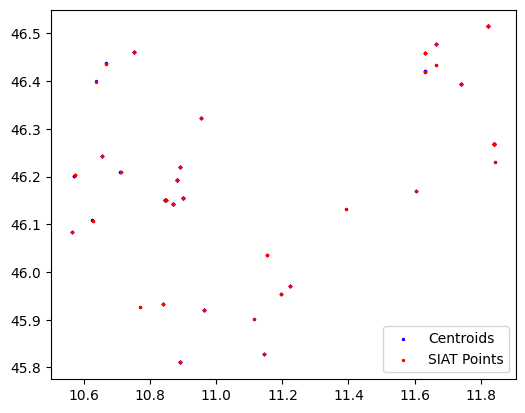

In [26]:
# Check with plot

# Recover the centroid points from the x and y columns
polygons_gdf['centroid'] = polygons_gdf.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)
# Create a GeoDataFrame for centroids
centroids_gdf = gpd.GeoDataFrame(polygons_gdf[['rifugio_nome', 'centroid']], geometry='centroid')

# Create a GeoDataFrame for the SIAT points using the extracted coordinates
siat_points_gdf = gpd.GeoDataFrame(
    polygons_gdf[['standardized_name', 'siat_point_x', 'siat_point_y']],
    geometry=[Point(xy) for xy in zip(polygons_gdf['siat_point_x'], polygons_gdf['siat_point_y'])],
    crs=polygons_gdf.crs
)

# Plotting
fig, ax = plt.subplots()
centroids_gdf.plot(ax=ax, color='blue', markersize=2, label='Centroids')
siat_points_gdf.plot(ax=ax, color='red', marker='o', markersize=2, label='SIAT Points')
plt.legend()
plt.show()

# Delete centroid column (extra geometry)
polygons_gdf = polygons_gdf.drop(columns=['centroid'])

In [27]:
# Save final polygon DataFrame
polygons_gdf.to_file("../data/huts_joined.geojson")

# Data Exploration


Categoria CAISAT

In [28]:
# Create a geometry column from siat_point_x and siat_point_y
polygons_gdf['geometry_siat_point'] = gpd.points_from_xy(polygons_gdf['siat_point_x'], polygons_gdf['siat_point_y'])
# Set the GeoDataFrame's geometry to the new geometry column
polygons_gdf_pointgeom = gpd.GeoDataFrame(polygons_gdf, geometry='geometry_siat_point')
polygons_gdf_pointgeom.set_geometry('geometry_siat_point')

## Optionally remove the polygon geometry column
# polygons_gdf_pointgeom = polygons_gdf_pointgeom.drop(columns=['geometry'])
# polygons_gdf_pointgeom = polygons_gdf_pointgeom.rename(columns={'geometry_siat_point': 'geometry'})

,rifugio_nome,categoria_CAISAT,categoria_PAT,quota,posti_letto,PT_TYPE,PT_CODE,PT_CCAT,PT_FABB,PT_PUB,geometry,centroid_x,centroid_y,standardized_name,siat_point_x,siat_point_y,geometry_siat_point
0,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,N,YES,"POLYGON ((11.14523 45.82734, 11.14514 45.82733...",11.144756,45.827381,alpepozzavincenzolancia,11.144705,45.827291,POINT (11.14471 45.82729)
1,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,P,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.14487 45.82735,...",11.144756,45.827381,alpepozzavincenzolancia,11.144705,45.827291,POINT (11.14471 45.82729)
2,"Alpe Pozza - ""V.Lancia""",C,Alp,1.802,50,C,.690,404,S,YES,"POLYGON ((11.1448 45.82735, 11.1448 45.82735, ...",11.144756,45.827381,alpepozzavincenzolancia,11.144705,45.827291,POINT (11.14471 45.82729)
3,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,P,.1367,44,N,YES,"POLYGON ((10.89031 45.81007, 10.89031 45.81007...",10.890453,45.810334,altissimodamianochiesa,10.890370,45.810385,POINT (10.89037 45.81038)
4,"Altissimo - ""D.Chiesa""",C,Alp,2.060,35,C,.1367,44,S,YES,"POLYGON ((10.89047 45.81044, 10.89031 45.81042...",10.890453,45.810334,altissimodamianochiesa,10.890370,45.810385,POINT (10.89037 45.81038)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Val di Fumo,D,Alp,1.918,56,P,.813,125,N,YES,"POLYGON ((10.56213 46.08378, 10.56176 46.08415...",10.562472,46.084219,valdifumo,10.562530,46.084449,POINT (10.56253 46.08445)
137,Val di Fumo,D,Alp,1.918,56,C,.813,125,S,YES,"POLYGON ((10.56247 46.08433, 10.56245 46.08438...",10.562472,46.084219,valdifumo,10.562530,46.084449,POINT (10.56253 46.08445)
138,Val di Fumo,D,Alp,1.918,56,C,.813,125,S,YES,"POLYGON ((10.56242 46.08419, 10.5624 46.08423,...",10.562472,46.084219,valdifumo,10.562530,46.084449,POINT (10.56253 46.08445)
139,Velo Madonna,D,Alp,2.333,62,P,1918/4,353,N,YES,"POLYGON ((11.84297 46.23125, 11.84271 46.23128...",11.842864,46.231353,velodellamadonna,11.842651,46.231353,POINT (11.84265 46.23135)


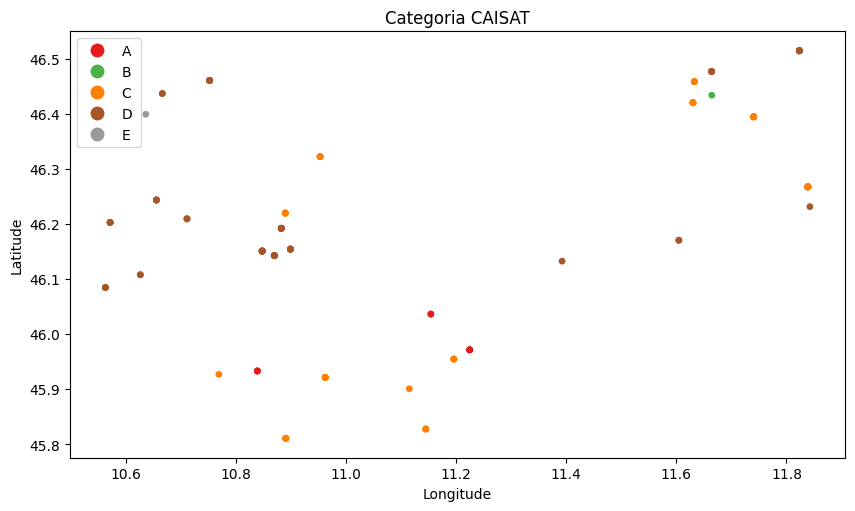

In [29]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
polygons_gdf_pointgeom.plot(column='categoria_CAISAT', ax=ax, markersize=15, legend=True, cmap='Set1')
ax.set_title('Categoria CAISAT')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [30]:
polygons_gdf['categoria_CAISAT'].value_counts()

categoria_CAISAT
D     74
C     56
A      9
B      1
E      1
Name: count, dtype: int64

Categoria PAT

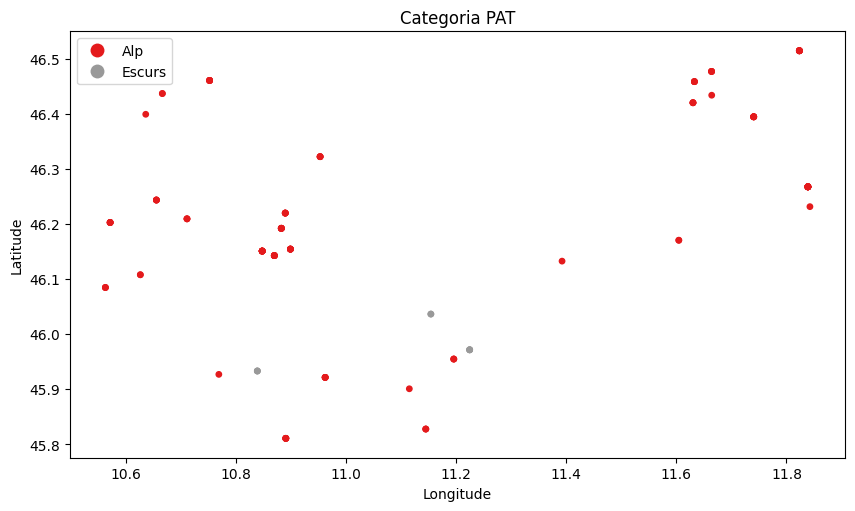

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
polygons_gdf_pointgeom.plot(column='categoria_PAT', ax=ax, markersize=15, legend=True, cmap='Set1')
ax.set_title('Categoria PAT')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()